# Word2Vec Skip-gram 模型
TensorFlow 1.x 实现

In [1]:
import collections
import zipfile
import random
import math

import numpy as np
import tensorflow as tf

## Step 1: 读取数据

In [2]:
def read_data(filename):
    """Read the file data"""
    with open(filename) as f:
        with zipfile.ZipFile(filename) as f:
            data = tf.compat.as_str(f.read(f.namelist()[0])).split()
        return data

In [3]:
filename = "E:/Code/play_python/word2vec/text8.zip"
original_words = read_data(filename)
print('Data size', len(original_words))

Data size 17005207


## Step 2: 生成词汇字典，用 UNK 替换不常见单词

In [4]:
vocabulary_size = 50000

In [5]:
def build_vocabulary(original_words):
    # 创建一个名为 count 的列表，包含“UNK”（出现频率较低的单词）
    count = [["UNK", -1]]

    # extend()函数会在列表末尾一次性追加另一个序列中的多个值(用于扩展原来的列表）
    count.extend(collections.Counter(original_words).most_common(vocabulary_size - 1))

    dictionary = dict()
    # 遍历 count，并将 count 中按频率顺序排列好的单词装入dictionary，word为键
    # len(dictionary)为键值，这样可以在 dictionary 中按 0 到 49999 的编号引用单词
    for word, _ in count:
        dictionary[word] = len(dictionary)

    data = list()
    unknown_count = 0 # UNK
    # 遍历original_words原始单词列表，该列表并没有将单词按频率顺序排列好
    for word in original_words:
        if word in dictionary:  # original_words列表中的单词是否出现在dictionary中
            index = dictionary[word]  # 取得该单词在dictionary中的编号赋值给index
        else:
            index = 0  # 没有出现在dictionary中的单词，index将被赋值0
            unknown_count += 1  # 计数这些单词
        data.append(index)

    # 将 UNK 类型的单词数量赋值到 count 列表的第[0][1]个元素
    count[0][1] = unknown_count
    # 反转 dictionary 中的键值和键，并存入另一个字典中
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

In [6]:
# data 是词汇数据转化成 dictionary 的字典后的列表
# count 是包含所有词汇计数且排序后的列表
# dictionary 是 {word:id} 的 dictionary
# reverse_dictionary 是 dictionary 转换后 {id:word} 的 dictionary
data, count, dictionary, reverse_dictionary = build_vocabulary(original_words)
del original_words # 节约内存

# 打印 top5 的单词的数量，包括 UNK
print("Most common words (+UNK)", count[:5])
# 打印data中前十个单词及其编号
print("Sample data", data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


## Step 3: 生成 skip-gram 模型的训练批次
例如   
句子："The dog barked at the mailman"   
选取 input word：dog   
设置 skip_window = 2、num_skips = 2   
skip_window 为 2，则产生窗口为：['The','dog','barked','at']   
num_skips 为 2，得到(input word,output word)形式的训练数据：(dog,barked)、(dog,the)   

In [7]:
data_index = 0

In [8]:
# batch_size：批次数量，即选取多少个数据
# skip_window: input word 的一侧（左边或右边）选取词的数量，组成一个 [ skip_window target skip_window ] 的窗口
# num_skips：从整个窗口中选取多少个不同的词作为我们的 output word（num_skips 通常为偶数）
# 
# data_index 控制，每次调用取一批
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(
        maxlen=span)  # pylint: disable=redefined-builtin
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index - span) % len(data)
    return batch, labels

## Step 4: Skip-Gram 算法

### 定义一些超参数

In [9]:
embedding_size = 128  # 词嵌入维度
skip_window = 3  # input word 的一侧（左边或右边）选取词的数量
num_skips = 2  # 从整个窗口中选取不同的词作为 output word 的数量
num_sampled = 64  # Negative Sampling 时，negative examples 的数量

learning_rate = 1.0 # 学习率
batch_size = 128 # 每批次的数量
num_steps = 200000  # 训练最大迭代次数
display_step = 5000 # 每这么多次打印一遍 loss 值
eval_step = 40000 # 每这么多次评估一次模型

### 验证集

In [10]:
# 在选择时，选择一些常用词以及一些少见的单词；是一个包含 ID 的 array
valid_examples = np.array(random.sample(range(50), 5)) # 5个常见
valid_examples = np.append(valid_examples, random.sample(range(20000, 20000 + 50), 5), axis=0) # 5个少见

### 模型定义和训练

In [11]:
with tf.Graph().as_default():
    # 模型定义
    # train_inputs 和 train_labels 是训练数据及其 label 的 placeholder
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    # embeddings是所有50000高频单词的词向量，向量的维度是128，数值是由 random_uniform() 函数生成的在-1.0到1.0之间平均分布的数值
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

    # embedding_lookup()函数用于选取一个张量里面索引对应的元素，函数原型是：
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # 用 truncated_normal() 函数产生标准差为 1.0/math.sqrt(embedding_size) 的正态分布数据
    # 产生的 nce_weights 作为 NCE loss 中的权重参数
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                  stddev=1.0 / math.sqrt(embedding_size)))

    # 产生的nce_biases作为NCE loss中的偏置参数
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # 计算词向量 embedding 在训练数据上的 loss
    nec_loss = tf.nn.nce_loss(
        weights=nce_weights,
        biases=nce_biases,
        labels=train_labels,
        inputs=embed,
        num_sampled=num_sampled,
        num_classes=vocabulary_size
    )
    # 求nce_loss的均值
    loss = tf.reduce_mean(nec_loss)

    # 创建优化器，学习率为固定的1.0，最小化loss
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

    # 定义计算相似度 similarity
    # 标准化
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    # 在标准化后的所有单词的词向量值中寻找验证集对应的词向量值
    valid_inputs = tf.constant(valid_examples, dtype=tf.int32)
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_inputs)
    # 相似度计算
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # 模型训练
    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        # 总损失与平均损失
        total_loss = 0
        average_loss = 0

        for step in range(1, num_steps + 1):
            # 生成训练批次
            batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)

            # 运行 loss 的计算及最小化 loss 的优化器
            loss_val, _ = sess.run([loss, optimizer], feed_dict={train_inputs: batch_inputs,
                                                                 train_labels: batch_labels})

            # 计算 total_loss 总损失
            total_loss += loss_val

            # 每进行 display_step 轮迭代就输出平均损失的值
            if step % display_step == 0:
                average_loss = total_loss / 1000
                print("Step %d, average loss is:%f " % (step, average_loss))
                average_loss = 0 #归0
                total_loss = 0 #归0

            # 每隔 eval_step 轮就打印一次与验证单词最相似的 top_k 个单词
            if step == 1 or step % eval_step == 0:
                # 执行计算相似性的操作
                similar = similarity.eval()
                for i in range(len(valid_examples)):
                    top_k = 8 
                    # 每执行一次最外层的循环，都会得到一个验证单词对应的nearest，
                    # 这里有8个数据，是与验证单词最相近的单词的编号，通过 reverse_dictionary 可以得到确切的单词
                    nearest = (-similar[i, :]).argsort()[1:top_k + 1]
                    log_str = '"%s" nearest neighbors:' % reverse_dictionary[valid_examples[i]]

                    for k in range(top_k):
                        log_str = '%s %s' % (log_str, reverse_dictionary[nearest[k]])
                    print(log_str)
        final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
"five" nearest neighbors: finkel gr falwell lars bartolommeo pel plucking unspecific
"zero" nearest neighbors: endorses incalculable neglected expectancies cowardly conformation j orchestrated
"two" nearest neighbors: kowtow voortrekkers laguardia hbp monrovia publique lifeform leah
"with" nearest neighbors: moseley ncipe couper pulsar revoluci dismayed hestia emulsions
"eight" nearest neighbors: trioxide decided implied mrna perturbations landesverband pago coretta
"colombo" nearest neighbors: mcclelland thymus bitchx lago crypt bought howl might
"auchinleck" nearest neighbors: spur yolk walken conditioned degrading numerals infringing starters
"cvn" nearest neighbors: volleys quanta nils deceive rb tremor maud plowman
"humbert" nearest neighbors: deliberate fourteen enid worrying possessor avalanches moxie mahagonny
"meps" nearest neighbors: breakup recognises leap marxist girls keen seasons

## *Step 5: 可视化 Skip-gram 模型训练后结果

In [12]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from matplotlib import pylab
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [13]:
def find_clustered_embeddings(embeddings, distance_threshold, sample_threshold):
     # 计算余弦（cosine）相似度
    cosine_sim = np.dot(embeddings, np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings ** 2, axis=1).reshape(-1, 1),
                  np.sum(np.transpose(embeddings) ** 2, axis=0).reshape(1, -1))
    assert cosine_sim.shape == norm.shape
    cosine_sim /= norm

    # 使所有对角线条目为零，否则将被选为最高项
    np.fill_diagonal(cosine_sim, -1.0)

    argmax_cos_sim = np.argmax(cosine_sim, axis=1)
    mod_cos_sim = cosine_sim
    # 如果有超过阈值的n个项目，则查找循环中的最大值以进行计数
    for _ in range(sample_threshold - 1):
        argmax_cos_sim = np.argmax(cosine_sim, axis=1)
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]), argmax_cos_sim] = -1

    max_cosine_sim = np.max(mod_cos_sim, axis=1)

    return np.where(max_cosine_sim > distance_threshold)[0]

In [14]:
# 我们将使用大样本空间来构建 T-SNE 流形(T-SNE manifold)，然后使用余弦相似性对其进行修剪
num_points = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('正在T-SNE 拟合嵌入...')
# 获取T-SNE流形
selected_embeddings = final_embeddings[:num_points, :]
two_d_embeddings = tsne.fit_transform(selected_embeddings)

print('正在裁剪 T-SNE 嵌入...')
# 通过获得仅高于相似性阈值的n个样本的嵌入来修剪嵌入
# 这会使视觉效果更加清晰
selected_ids = find_clustered_embeddings(selected_embeddings, .25, 10)
two_d_embeddings = two_d_embeddings[selected_ids, :]

print('在', num_points, '个样本 ', '之中,', '通过裁剪选择出', selected_ids.shape[0], '个样本。')

正在T-SNE 拟合嵌入...
正在裁剪 T-SNE 嵌入...
在 500 个样本  之中, 通过裁剪选择出 500 个样本。


In [15]:
### 用 Matplotlib 绘制 t-SNE 结果
def plot(embeddings, labels):
    n_clusters = 30  # 聚类（簇）数量
    # 自动构建一组离散的颜色，每个颜色都用于聚类
    label_colors = [pylab.cm.nipy_spectral(float(i) / n_clusters) for i in range(n_clusters)]

    assert embeddings.shape[0] >= len(labels), '多于嵌入的标签'

    # 定义 K-Means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(embeddings)
    kmeans_labels = kmeans.labels_

    pylab.figure(figsize=(15, 15))  # in inches

    # 绘制所有嵌入及其相应的单词
    for i, (label, klabel) in enumerate(zip(labels, kmeans_labels)):
        x, y = embeddings[i, :]
        pylab.scatter(x, y, c=label_colors[klabel])

        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom', fontsize=10)

    # 如果需要，用于保存图像
    # pylab.savefig('word_embeddings.png')
    pylab.show()

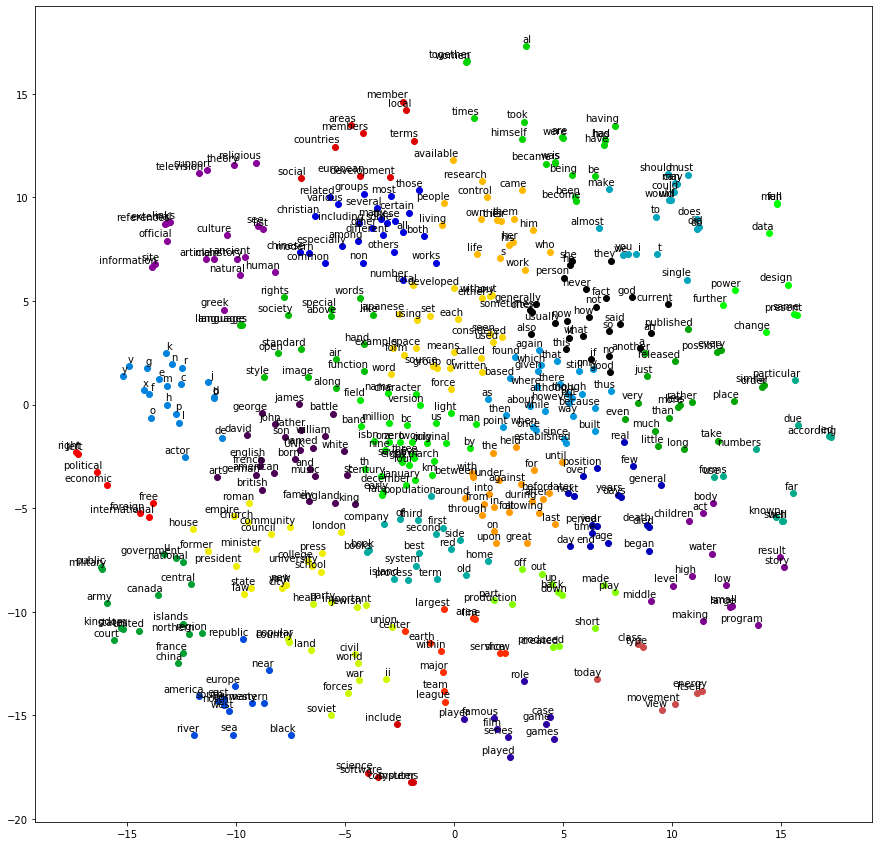

In [16]:
words = [reverse_dictionary[i] for i in selected_ids]
plot(two_d_embeddings, words)